# Using H2o AutoML to predict house prices

In [30]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/california-house-prices/sample_submission.csv
/kaggle/input/california-house-prices/train.csv
/kaggle/input/california-house-prices/test.csv


In [31]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

from pandas_profiling import ProfileReport
import seaborn as sns
from sklearn import metrics
from scipy import stats

from copy import deepcopy

import h2o

## 1.Data Clean
### (1) 导入并观察数据

In [32]:
train_df = pd.read_csv('/kaggle/input/california-house-prices/train.csv')
test_df = pd.read_csv('/kaggle/input/california-house-prices/test.csv')
train_df.shape, test_df.shape

((47439, 41), (31626, 40))

- 根据以下散点图，删除离群点

In [34]:
train_df=train_df.drop([3674,6055,32867,34876,43398,44091,44633])

In [35]:
data = pd.concat([train_df['Sold Price'], train_df['Listed Price']], axis=1)
fig = px.scatter(data, x='Listed Price', y='Sold Price')
fig.show()

In [36]:
data = pd.concat([train_df['Sold Price'], train_df['Tax assessed value']], axis=1)
fig = px.scatter(data, x='Tax assessed value', y='Sold Price')
fig.show()

In [39]:
data = pd.concat([train_df['Sold Price'], train_df['Annual tax amount']], axis=1)
fig = px.scatter(data, x='Annual tax amount', y='Sold Price')
fig.show()

In [40]:
data = pd.concat([train_df['Sold Price'], train_df['Last Sold Price']], axis=1)
fig = px.scatter(data, x='Last Sold Price', y='Sold Price')
fig.show()

In [41]:
# Split features and labels
y = train_df['Sold Price'].reset_index(drop=True)
train_features = train_df.drop('Sold Price', axis=1)
test_features = test_df.copy()

features = pd.concat([train_features, test_features]).reset_index(drop=True)
features.shape

(79058, 40)

- 初步处理数据  zip列应作为字符串 并对bedroom列作简单处理

In [42]:
def proc_bedroom(x):
    if not pd.isna(x) and not x.isdigit():
        temp = x.split(',')
        n = len(x.split(','))
        if 'Walk-in Closet' in temp:
            n -= 1
        return n
    else:
        return x

features['Bedrooms']=features['Bedrooms'].apply(lambda x: proc_bedroom(x))
features['Bedrooms'] = pd.to_numeric(features['Bedrooms'])
features['Zip'] = features['Zip'].astype('str')

- 缺省值填充

In [43]:
#missing data
total = features.isnull().sum().sort_values(ascending=False)
percent = ((features.isnull().sum() / features.isnull().count()) * 100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data = missing_data.reset_index()
missing_data.columns = ['Name', 'Total', 'Percent']
missing_data[:10]

,Name,Total,Percent
0,Last Sold Price,29544,37.370032
1,Last Sold On,29544,37.370032
2,Middle School Score,28276,35.766146
3,Middle School Distance,28274,35.763617
4,Middle School,28274,35.763617
5,Appliances included,23347,29.531483
6,Lot,22987,29.076121
7,Flooring,21924,27.731539
8,Laundry features,19980,25.272585
9,Cooling features,16632,21.037719


In [44]:
def handle_missing(features):
    zero_fill=['Last Sold Price','Lot','Full bathrooms','Annual tax amount','Tax assessed value','Bathrooms',
               'Bedrooms','Total interior livable area','Total spaces','Garage spaces']
    none_fill=['Last Sold On','Middle School','Appliances included','Flooring','Laundry features','Cooling features',
               'Cooling','Heating features','Heating','Elementary School','High School','Parking features','Parking','Summary']
    max_fill=['Middle School Score','Middle School Distance','Elementary School Score','Elementary School Distance',
              'High School Score','High School Distance']
    mode_fill=['Year built','Region']
    for c in zero_fill:
        features[c]=features[c].fillna(0)
    for c in max_fill:
        features[c]=features[c].fillna(features[c].max())
    for c in none_fill:
        features[c]=features[c].fillna('None')
    for c in mode_fill:
        features[c]=features[c].fillna(features[c].mode()[0])
    return features

In [45]:
features = handle_missing(features)
features.shape

(79058, 40)

- 数据转换

In [46]:
# I want to thanks @masumrumi for sharing this amazing plot!
def plotting_3_chart(df, feature):
    ## Importing seaborn, matplotlab and scipy modules. 
    import seaborn as sns
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    from scipy import stats
    import matplotlib.style as style
    style.use('fivethirtyeight')

    ## Creating a customized chart. and giving in figsize and everything. 
    fig = plt.figure(constrained_layout=True, figsize=(12,8))
    ## creating a grid of 3 cols and 3 rows. 
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)
    #gs = fig3.add_gridspec(3, 3)

    ## Customizing the histogram grid. 
    ax1 = fig.add_subplot(grid[0, :2])
    ## Set the title. 
    ax1.set_title('Histogram')
    ## plot the histogram. 
    sns.distplot(df.loc[:,feature], norm_hist=True, ax = ax1)

    # customizing the QQ_plot. 
    ax2 = fig.add_subplot(grid[1, :2])
    ## Set the title. 
    ax2.set_title('QQ_plot')
    ## Plotting the QQ_Plot. 
    stats.probplot(df.loc[:,feature], plot = ax2)

    ## Customizing the Box Plot. 
    ax3 = fig.add_subplot(grid[:, 2])
    ## Set title. 
    ax3.set_title('Box Plot')
    ## Plotting the box plot. 
    sns.boxplot(df.loc[:,feature], orient='v', ax = ax3 );

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/opt/conda/lib/python3.7/site-packages/seaborn/_core.py:1319: UserWarning:

Vertical orientation ignored with only `x` specified.



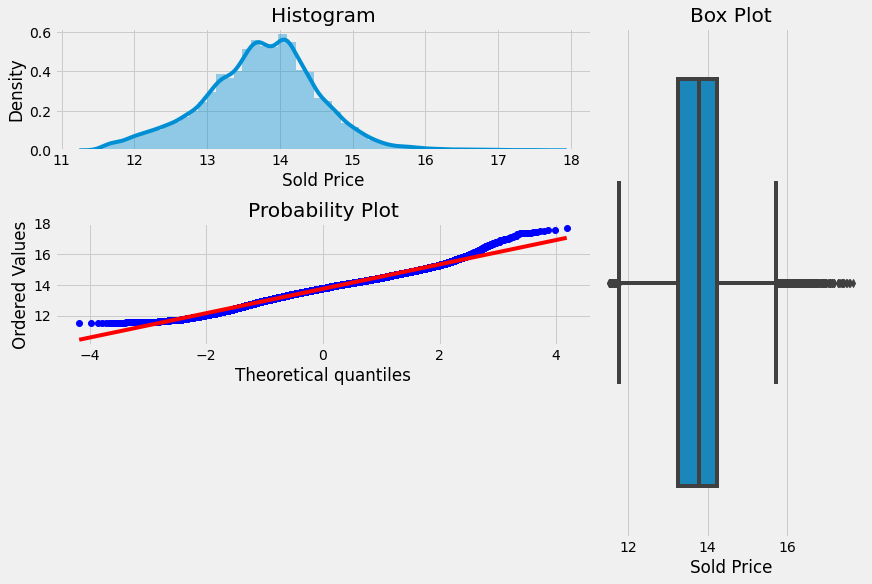

In [47]:
# Fix the target variable
y = np.log1p(y)

plotting_3_chart(pd.DataFrame(y), 'Sold Price')

In [48]:
numerical_columns = features.select_dtypes(include=['int64','float64']).columns

skewed_features = features[numerical_columns].apply(lambda x: stats.skew(x)).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew value' :skewed_features})
skewness.head(20)

,Skew value
Total interior livable area,281.156484
Garage spaces,170.008855
Total spaces,167.692773
Lot,102.909470
Annual tax amount,15.983229
Listed Price,12.216883
Tax assessed value,10.752594
Last Sold Price,10.187426
High School Distance,2.749617
Elementary School Distance,2.481876


In [49]:
def fix_skew(features):
    """
    This function takes in a dataframe and return fixed skewed dataframe
    """
    ## Import necessary modules 
    from scipy.special import boxcox1p
    from scipy.stats import boxcox_normmax
    
    ## Getting all the data that are not of "object" type. 
    numerical_columns = features.select_dtypes(include=['int64','float64']).columns

    # Check the skew of all numerical features
    skewed_features = features[numerical_columns].apply(lambda x: stats.skew(x)).sort_values(ascending=False)
    high_skew = skewed_features[abs(skewed_features) > 0.5]
    skewed_features = high_skew.index

    # Perform the Box-Cox transformation
    for column in skewed_features:
        features[column] = boxcox1p(features[column], boxcox_normmax(features[column] + 1))
        
    return features

In [50]:
def reset_zero(x):
    return max(x,0)
features['Garage spaces']=features['Garage spaces'].apply(lambda x: reset_zero(x))
features['Total spaces']=features['Total spaces'].apply(lambda x: reset_zero(x))
features = fix_skew(features)
features.head()

,Id,Address,Summary,Type,Year built,Heating,Cooling,Parking,Lot,Bedrooms,...,Parking features,Tax assessed value,Annual tax amount,Listed On,Listed Price,Last Sold On,Last Sold Price,City,Zip,State
0,0,540 Pine Ln,"540 Pine Ln, Los Altos, CA 94022 is a single f...",SingleFamily,15119.691345,"Heating - 2+ Zones, Central Forced Air - Gas","Multi-Zone, Central AC, Whole House / Attic Fan","Garage, Garage - Attached, Covered",0.726817,2.872963,...,"Garage, Garage - Attached, Covered",371.975396,82.746240,2019-10-24,80.119545,None,0.000000,Los Altos,94022,CA
1,1,1727 W 67th St,"HURRY, HURRY.......Great house 3 bed and 2 bat...",SingleFamily,14690.878725,Combination,"Wall/Window Unit(s), Evaporative Cooling, See ...","Detached Carport, Garage",15.385002,2.271049,...,"Detached Carport, Garage",303.655567,63.530064,2019-10-16,53.478514,2019-08-30,476.388851,Los Angeles,90047,CA
2,2,28093 Pine Ave,'THE PERFECT CABIN TO FLIP! Strawberry deligh...,SingleFamily,15009.721945,Forced air,None,0 spaces,18.048406,1.615347,...,None,130.862842,23.052044,2019-08-25,43.175687,None,0.000000,Strawberry,95375,CA
3,3,10750 Braddock Dr,Rare 2-story Gated 5 bedroom Modern Mediterran...,SingleFamily,14899.939865,Central,Central Air,"Detached Carport, Driveway, Garage - Two Door",0.000000,3.435215,...,"Detached Carport, Driveway, Garage - Two Door",477.611531,99.906213,2019-10-24,68.741724,2016-08-30,900.161285,Culver City,90230,CA
4,4,7415 O Donovan Rd,Beautiful 200 acre ranch land with several pas...,VacantLand,15631.976128,None,None,0 spaces,0.000000,0.000000,...,None,0.000000,0.000000,2019-06-07,66.482826,2016-06-27,726.987390,Creston,93432,CA


- 将features分离  根据Variable Importances进行挑选

In [51]:
x = features.iloc[:len(y), :]
x_test = features.iloc[len(y):, :]
x.shape, y.shape, x_test.shape

((47432, 40), (47432,), (31626, 40))

In [52]:
selected=['Listed Price','Tax assessed value','Annual tax amount','Listed On','Elementary School Distance','Last Sold On',
'Zip','Total interior livable area','Last Sold Price','Lot','Year built','Bathrooms','High School Distance',
'Elementary School Score','Full bathrooms','Middle School Distance','Heating features','Bedrooms',
'Elementary School','Laundry features','Region','Middle School Score','Type',
'Total spaces','High School Score','Parking']

x=x[selected]
x_test=x_test[selected+['Id']]
x.head()

,Listed Price,Tax assessed value,Annual tax amount,Listed On,Elementary School Distance,Last Sold On,Zip,Total interior livable area,Last Sold Price,Lot,...,Heating features,Bedrooms,Elementary School,Laundry features,Region,Middle School Score,Type,Total spaces,High School Score,Parking
0,80.119545,371.975396,82.746240,2019-10-24,0.247374,None,94022,0.756170,0.000000,0.726817,...,"Forced air, Gas",2.872963,Santa Rita Elementary School,"Washer / Dryer, Inside, In Utility Room",Los Altos,10.0,SingleFamily,0.000000,8.0,"Garage, Garage - Attached, Covered"
1,53.478514,303.655567,63.530064,2019-10-16,0.351259,2019-08-30,90047,17.557622,476.388851,15.385002,...,Combination,2.271049,Raymond Avenue Elementary School,Inside,Los Angeles,2.0,SingleFamily,0.687612,2.0,"Detached Carport, Garage"
2,43.175687,130.862842,23.052044,2019-08-25,0.517167,None,95375,19.097369,0.000000,18.048406,...,Forced air,1.615347,None,None,Strawberry,10.0,SingleFamily,0.000000,10.0,0 spaces
3,68.741724,477.611531,99.906213,2019-10-24,0.153660,2016-08-30,90230,24.291661,900.161285,0.000000,...,Central,3.435215,Farragut Elementary School,"Stackable, Upper Level",Culver City,7.0,SingleFamily,0.000000,8.0,"Detached Carport, Driveway, Garage - Two Door"
4,66.482826,0.000000,0.000000,2019-06-07,0.510700,2016-06-27,93432,0.000000,726.987390,0.000000,...,None,0.000000,Santa Margarita Elementary School,None,Creston,5.0,VacantLand,0.000000,6.0,0 spaces


## 2.train

In [53]:
import h2o

h2o.init()
hf = h2o.H2OFrame(pd.concat([x, y], axis=1))
x_test_hf = h2o.H2OFrame(x_test)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,3 mins 19 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.1
H2O_cluster_version_age:,1 month and 17 days
H2O_cluster_name:,H2O_from_python_unknownUser_gimna4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.985 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [54]:
predictors = hf.drop('Sold Price').columns
response = 'Sold Price'

In [55]:
from h2o.automl import H2OAutoML

# stopping_metric: Specify the metric to use for early stopping. 
aml = H2OAutoML(
    max_models=50,
    include_algos=["XGBoost"],
    max_runtime_secs=7200,
    stopping_metric='RMSLE',
    sort_metric='RMSLE'
)

In [56]:
# Train the model
aml.train(x=predictors,y=response,training_frame=hf)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [57]:
lb = aml.leaderboard; lb

model_id,rmsle,mean_residual_deviance,rmse,mse,mae
XGBoost_grid__1_AutoML_20210513_035748_model_33,0.0130972,0.035804,0.189219,0.035804,0.091789
XGBoost_grid__1_AutoML_20210513_035748_model_16,0.013202,0.0363128,0.190559,0.0363128,0.0915797
XGBoost_grid__1_AutoML_20210513_035748_model_2,0.0132079,0.036406,0.190804,0.036406,0.0933205
XGBoost_grid__1_AutoML_20210513_035748_model_30,0.0132156,0.0363194,0.190576,0.0363194,0.0915061
XGBoost_grid__1_AutoML_20210513_035748_model_31,0.0132311,0.0365061,0.191066,0.0365061,0.0914037
XGBoost_grid__1_AutoML_20210513_035748_model_39,0.0132554,0.0366788,0.191517,0.0366788,0.0928424
XGBoost_grid__1_AutoML_20210513_035748_model_46,0.0132786,0.0368897,0.192067,0.0368897,0.0932486
XGBoost_grid__1_AutoML_20210513_035748_model_15,0.0132832,0.0369069,0.192112,0.0369069,0.0935949
XGBoost_grid__1_AutoML_20210513_035748_model_9,0.0133054,0.0368809,0.192044,0.0368809,0.0944703
XGBoost_grid__1_AutoML_20210513_035748_model_28,0.0133309,0.0371643,0.19278,0.0371643,0.0951313


## 3.predict

In [58]:
aml.leader

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid__1_AutoML_20210513_035748_model_33


Model Summary: 


,,number_of_trees
0,,74.0




ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 0.011661139550476908
RMSE: 0.10798675636612533
MAE: 0.05705585753581922
RMSLE: 0.00745891154333034
Mean Residual Deviance: 0.011661139550476908

ModelMetricsRegression: xgboost
** Reported on cross-validation data. **

MSE: 0.03580399086543327
RMSE: 0.1892194251799568
MAE: 0.09178895394583741
RMSLE: 0.013097170958722777
Mean Residual Deviance: 0.03580399086543327

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,0.09178899,0.0017559377,0.09150206,0.0902826,0.09084026,0.09152874,0.0947913
1,mean_residual_deviance,0.035804007,0.0019753736,0.03647416,0.03435171,0.033686977,0.035776146,0.038731042
2,mse,0.035804007,0.0019753736,0.03647416,0.03435171,0.033686977,0.035776146,0.038731042
3,r2,0.9434624,0.002813024,0.94412273,0.94656736,0.94448173,0.94320184,0.9389382
4,residual_deviance,0.035804007,0.0019753736,0.03647416,0.03435171,0.033686977,0.035776146,0.038731042
5,rmse,0.18916245,0.005193265,0.1909821,0.18534215,0.18354012,0.18914583,0.19680203
6,rmsle,0.013092434,3.9392256E-4,0.013275907,0.012748506,0.012731001,0.013035627,0.013671131



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2021-05-13 04:38:31,38 min 5.476 sec,0.0,13.262581,13.238679,175.896051
1,,2021-05-13 04:38:31,38 min 5.931 sec,5.0,2.285603,2.244786,5.223982
2,,2021-05-13 04:38:32,38 min 6.590 sec,10.0,0.466406,0.408750,0.217535
3,,2021-05-13 04:38:34,38 min 8.585 sec,15.0,0.220425,0.126931,0.048587
4,,2021-05-13 04:38:36,38 min 10.602 sec,20.0,0.183256,0.090155,0.033583
5,,2021-05-13 04:38:38,38 min 12.559 sec,25.0,0.166444,0.080142,0.027704
6,,2021-05-13 04:38:40,38 min 14.667 sec,30.0,0.155188,0.075368,0.024083
7,,2021-05-13 04:38:42,38 min 16.733 sec,35.0,0.146012,0.071706,0.021319
8,,2021-05-13 04:38:44,38 min 19.165 sec,40.0,0.139763,0.069457,0.019534
9,,2021-05-13 04:38:47,38 min 21.212 sec,45.0,0.133854,0.067270,0.017917



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,Listed Price,18998.871094,1.000000,0.836222
1,Tax assessed value,1292.500366,0.068030,0.056888
2,Listed On,409.502594,0.021554,0.018024
3,Zip,308.526093,0.016239,0.013580
4,Last Sold On,194.506699,0.010238,0.008561
5,Total interior livable area,192.687195,0.010142,0.008481
6,Annual tax amount,178.752579,0.009409,0.007868
7,Last Sold Price,166.954239,0.008788,0.007348
8,Lot,162.340698,0.008545,0.007145
9,Year built,126.088112,0.006637,0.005550



See the whole table with table.as_data_frame()


发现过拟合现象比较严重，这里考虑使用前k个模型的输出取均值进行整合

Reported on train data.

**RMSLE: 0.00745891154333034**

Reported on cross-validation data.

**RMSLE: 0.013097170958722777**

In [63]:
submission_results = pd.read_csv("/kaggle/input/california-house-prices/sample_submission.csv")
def top_k_avg_predict(k,leaderboard):
    lb=leaderboard.as_data_frame()
    ans=submission_results.iloc[:, 1]
    for i in range(k):
        model=lb.loc[i]['model_id']
        pred=h2o.get_model(model).predict(x_test_hf)
        pred=pred.as_data_frame()
        ans+=np.expm1(pred['predict'])/k
    return ans

submission_results.iloc[:, 1]=top_k_avg_predict(8,aml.leaderboard)
submission_results.head()
submission_results.to_csv('submission.csv', index=False)

xgboost prediction progress: |████████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%


In [64]:
submission_results.head()

,Id,Sold Price
0,47439,8.026259e+05
1,47440,5.783431e+05
2,47441,8.339634e+05
3,47442,7.981004e+05
4,47443,1.128515e+06
